In [1]:
#Let’s import all the libraries required
#Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#NLP for text pre-processing
import nltk
import scipy
import re
from scipy import spatial
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
tokenizer = ToktokTokenizer()

In [3]:
# other libraries
import gensim
from gensim.models import Word2Vec
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [4]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

In [5]:
# remove warnings
import warnings
warnings.filterwarnings(action = 'ignore')

In [6]:
data=pd.read_csv("flipkart_com-ecommerce_sample.csv")
data.head()
data.shape

(20000, 15)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  20000 non-null  object 
 1   crawl_timestamp          20000 non-null  object 
 2   product_url              20000 non-null  object 
 3   product_name             20000 non-null  object 
 4   product_category_tree    20000 non-null  object 
 5   pid                      20000 non-null  object 
 6   retail_price             19922 non-null  float64
 7   discounted_price         19922 non-null  float64
 8   image                    19997 non-null  object 
 9   is_FK_Advantage_product  20000 non-null  bool   
 10  description              19998 non-null  object 
 11  product_rating           20000 non-null  object 
 12  overall_rating           20000 non-null  object 
 13  brand                    14136 non-null  object 
 14  product_specifications

In [8]:
data['length']=data['description'].str.len()

In [9]:
data['no_of_words'] = data.description.apply(lambda x : len(str(x).split()))

In [10]:
bins=[0,50,75, np.inf]
data['bins']=pd.cut(data.no_of_words, bins=[0,100,300,500,800, np.inf],
                    labels=['0-100', '100-200', '200-500','500-800' ,'>800'])


In [11]:
words_distribution = data.groupby('bins').size().reset_index(). rename(columns={0:'word_counts'})

Text(0.5, 1.0, 'Word distribution per bin')

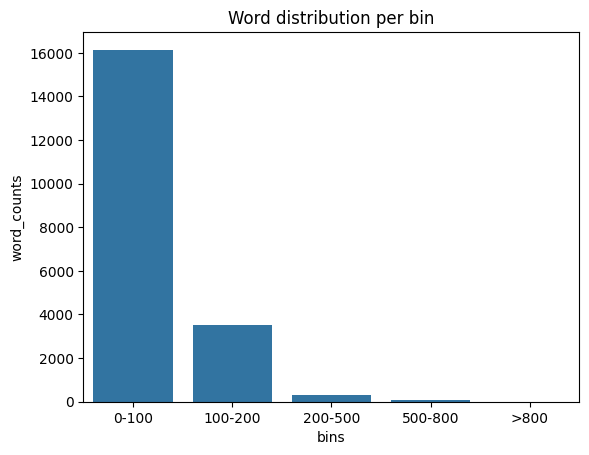

In [12]:
sns.barplot(x='bins', y='word_counts', data=words_distribution).set_title ("Word distribution per bin")

In [13]:
# Number of missing values in each column
missing = pd.DataFrame(data.isnull().sum()).rename(columns = {0:'missing'})

In [14]:
# Create a percentage of missing values
missing['percent'] = missing['missing'] / len(data)

In [15]:
# sorting the values in desending order to see highest count on the top
missing.sort_values('percent', ascending = False)

,missing,percent
brand,5864,0.29320
retail_price,78,0.00390
discounted_price,78,0.00390
product_specifications,14,0.00070
image,3,0.00015
length,2,0.00010
description,2,0.00010
uniq_id,0,0.00000
product_rating,0,0.00000
no_of_words,0,0.00000


In [20]:
data['description'] = data['description'].astype(str)
data['description'] = data['description'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))
# Replace whitespace between terms with a single space
data['description'] = data['description'].str.replace(r'\s+', ' ')
# Remove leading and trailing whitespace
data['description'] = data['description'].str.replace(r'^\s+|\s+?$', '')
# converting to lower case
data['description'] = data['description'].str.lower()

In [21]:
data['description'] = data['description'].astype(str)
data['description'] = data['description'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))

In [22]:
data['description'].head()

0    key features of alisha solid womens cycling sh...
1    fabhomedecor fabric double sofa bed finish col...
2    key features of aw bellies sandals wedges heel...
3    key features of alisha solid womens cycling sh...
4    specifications of sicons all purpose arnica do...
Name: description, dtype: object

In [30]:
import nltk
nltk.download('stopwords')
# Removing Stop words
stop = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop]
    return ' '.join(filtered_words)

# Apply the function to remove stopwords
data['description'] = data['description'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
# Removing single characters
data['description'] = data['description'].str.replace(r'\s+', ' ')
data['description'] = data['description'].apply(lambda x: " ".join(x for x in str(x).split() if len(x)>1))

In [35]:
# Removing domain related stop words from description
specific_stop_words = [ "rs","flipkart","flipkartcom","buy","com","free","day","cash","re placement","guarantee",
                       "genuine","key","feature","delivery","products","pro duct","shipping",
                       "online","india","shop"]
data['description'] = data['description'].apply(lambda x: " ".join(x for x in str(x).split() if x not in specific_stop_words))

In [36]:
data['description'].head()

0    features alisha solid womens cycling shorts co...
1    fabhomedecor fabric double sofa bed finish col...
2    features aw bellies sandals wedges heel casual...
3    features alisha solid womens cycling shorts co...
4    specifications sicons purpose arnica dog shamp...
Name: description, dtype: object

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


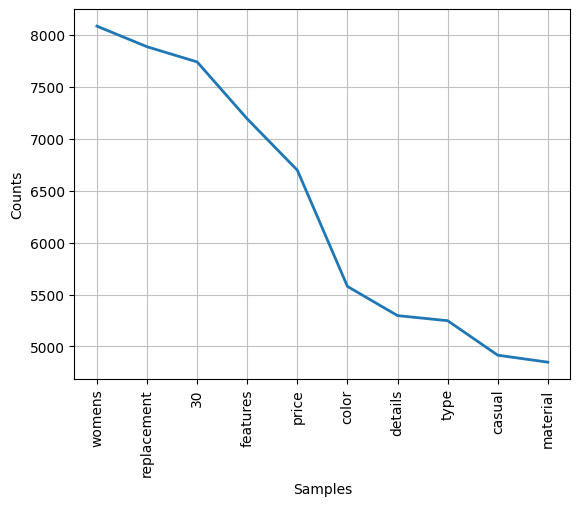

[('womens', 8082), ('replacement', 7884), ('30', 7738), ('features', 7190), ('price', 6696), ('color', 5578), ('details', 5297), ('type', 5248), ('casual', 4916), ('material', 4849)]


In [37]:
import nltk
nltk.download('punkt')
#Let’s also see what are the most occurred words in the corpus and understand the data better.
#Top frequent words after removing domain related stop words
a = data['description'].str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)
word_dist.plot(10,cumulative=False)
print(word_dist.most_common(10))

In [38]:
#Content-based Recommendation System
#Now that you know about content-based recommender systems, let’s start implementing one.
#For content-based systems, let’s use the TF-IDF approach.
#text cleaning
data['description'] = data['description'].fillna('')
#define the vectorizer
T_vec =  TfidfVectorizer(stop_words='english')
# get the vectors
T_vec_matrix = T_vec.fit_transform(data['description'])
#shape
T_vec_matrix.shape

(20000, 32510)

In [39]:
# Reversing the map of indices and product
product_index = pd.Series(data.index, index=data['product_name']).drop_duplicates()
product_index

product_name
Alisha Solid Women's Cycling Shorts            0
FabHomeDecor Fabric Double Sofa Bed            1
AW Bellies                                     2
Alisha Solid Women's Cycling Shorts            3
Sicons All Purpose Arnica Dog Shampoo          4
                                           ...  
WallDesign Small Vinyl Sticker             19995
Wallmantra Large Vinyl Stickers Sticker    19996
Elite Collection Medium Acrylic Sticker    19997
Elite Collection Medium Acrylic Sticker    19998
Elite Collection Medium Acrylic Sticker    19999
Length: 20000, dtype: int64